# LDA에서 Dynamic Topic Model

In [1]:
from IPython.display import Image

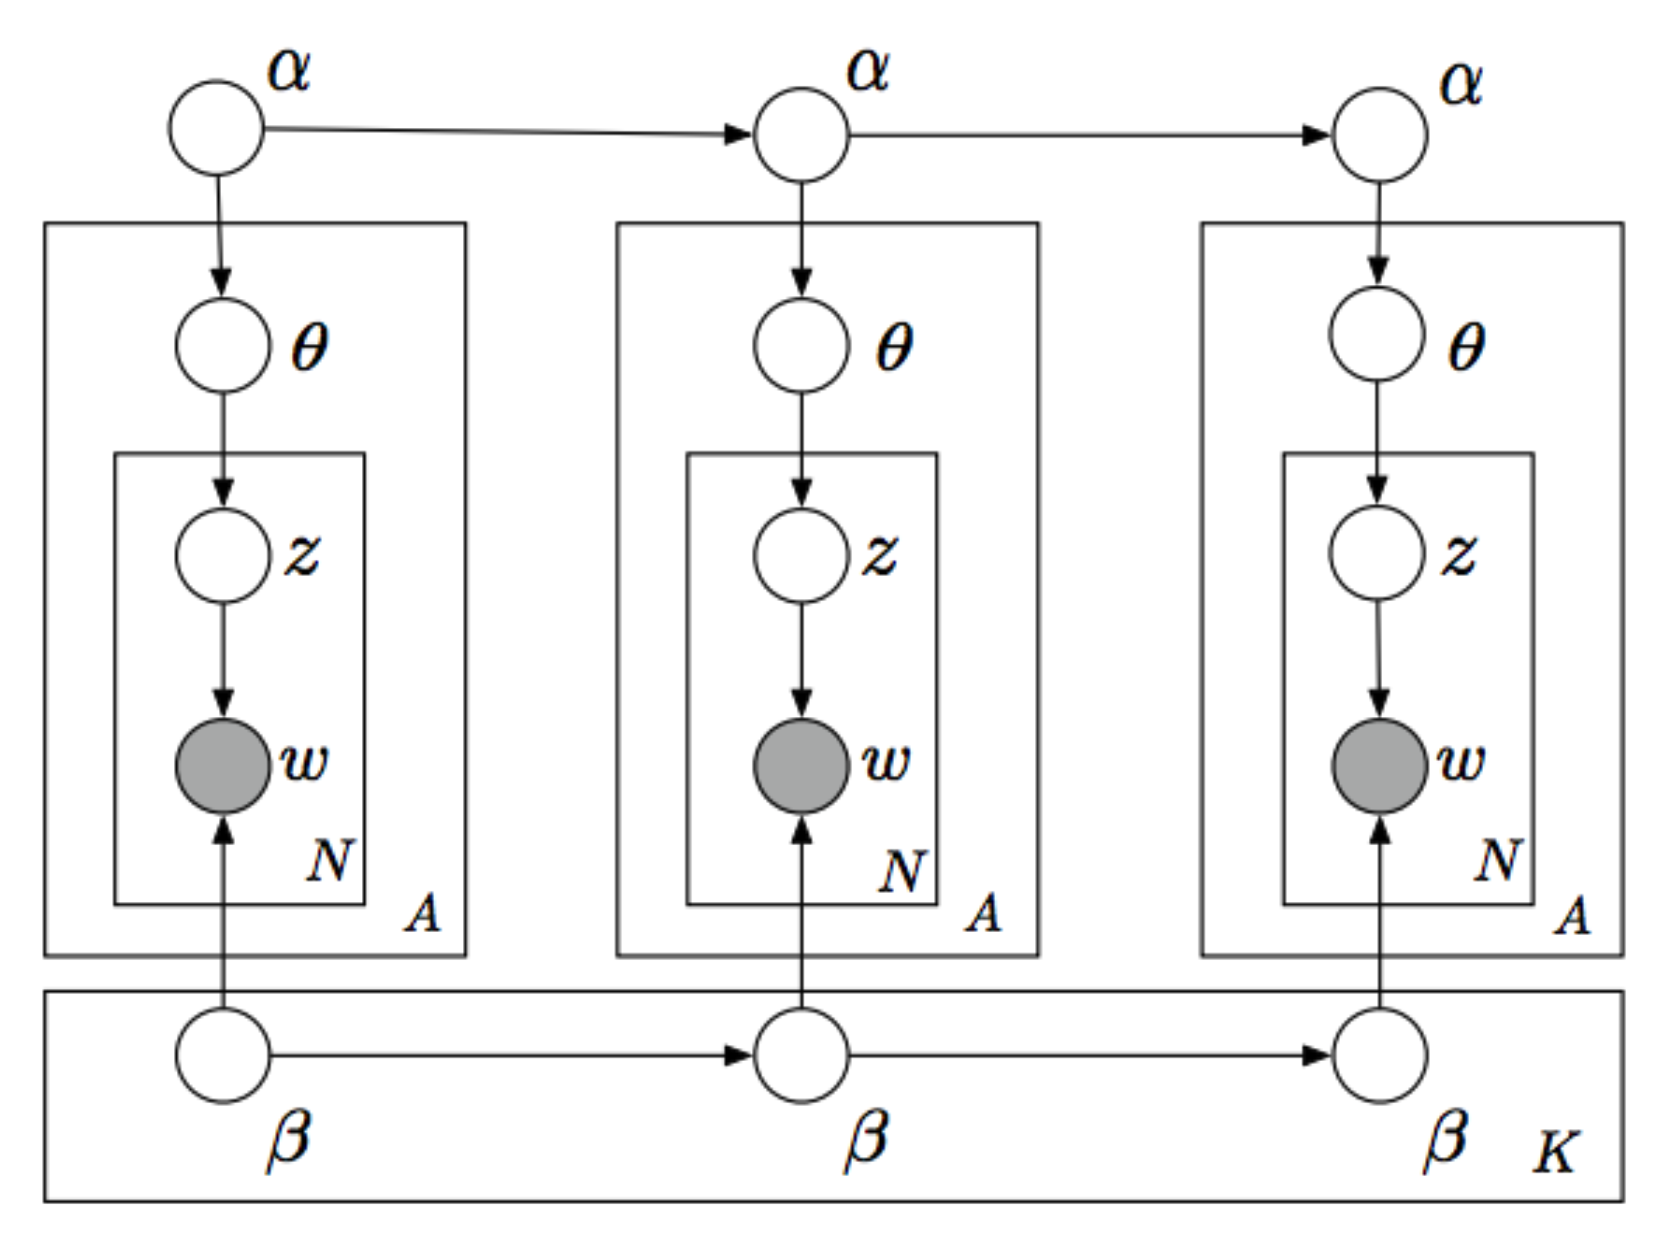

In [2]:
Image(filename='data/dtm_fig.png')

* 시간의 흐름에 따른 토픽 변화를 보여줌

* 시간대를 특정 단위로 나눠 time slice 단위별 LDA를 여러 개를 붙인 형태

* 토픽 분포에 해당하는 파라미터인 Beta값을 time slice가 넘어갈때 넘겨주는 것으로 시간대별 토픽 분포를 반영하게 함

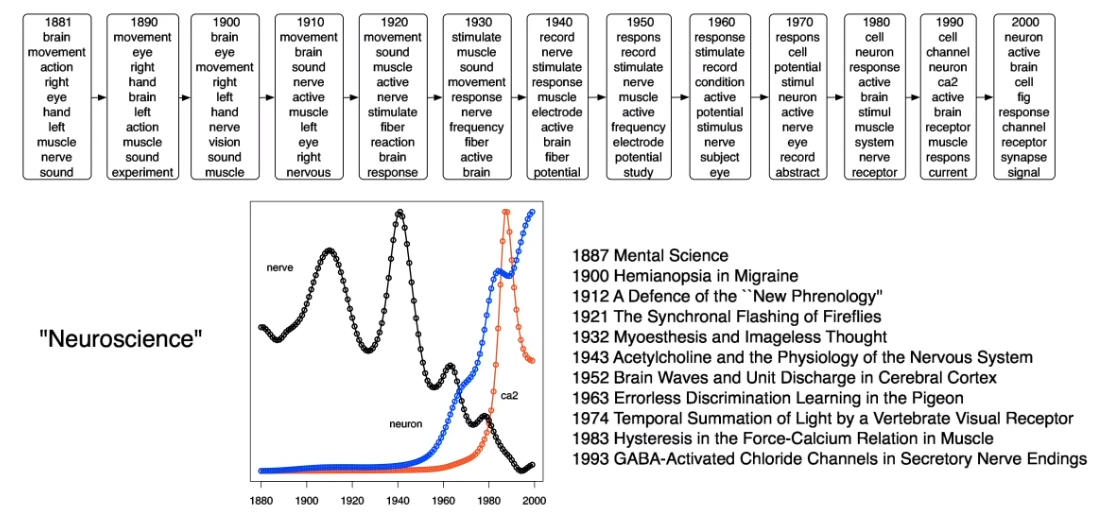

In [3]:
Image(filename='data/dtm_fig2.png')

### 1. 대화내용 불러오기

In [1]:
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
import re

In [2]:
# load data
with open("data/cleaned_katalk_data.pk", "rb") as f:
    data = pickle.load(f)
    
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14911 entries, 0 to 14910
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     14911 non-null  object
 1   user     14911 non-null  object
 2   message  14911 non-null  object
dtypes: object(3)
memory usage: 349.6+ KB
None


### 2. 분석시기 설정하기

In [3]:
# 시간정보 열을 datetime 정보로 변환
data['date'] = pd.to_datetime(data['date'])

# 인덱스 넣기
data = data.set_index('date')

data.head()

,user,message
date,,
2016-03-07 15:41:00,YH,안녕하세요 이게 빠르지 않을까 해서요 엠티 관련해서는 회장님께서 이미 밴드에 올려 ...
2016-03-07 15:51:00,WH,네 안녕하세요
2016-03-07 17:14:00,YH,넵 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까요 총무님
2016-03-07 17:21:00,KS,엠티관련해서 참석여부 투표를 말씀하신건가요
2016-03-07 17:22:00,YH,네 저희 이번 토욜 관련해서도 투표를 올려야 해서요


#### 시기별로 대화내용 분리

In [4]:
# 월별로 데이터 나누기

data_0 = data['2016-03-01' : '2016-03-31']
data_1 = data['2016-04-01' : '2016-04-20']
data_2 = data['2016-04-21' : '2016-04-30']

print(data_0.info())
print(data_1.info())
print(data_2.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1064 entries, 2016-03-07 15:41:00 to 2016-03-31 23:09:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user     1064 non-null   object
 1   message  1064 non-null   object
dtypes: object(2)
memory usage: 24.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5568 entries, 2016-04-01 10:01:00 to 2016-04-20 23:44:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user     5568 non-null   object
 1   message  5568 non-null   object
dtypes: object(2)
memory usage: 130.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8279 entries, 2016-04-21 11:11:00 to 2016-04-25 16:43:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user     8279 non-null   object
 1   message  8279 non-null   object
dtypes: object(2)
memory usage: 194.0

In [5]:
print(data_0.head())
print(data_1.head())
print(data_2.head())

                    user                                            message
date                                                                       
2016-03-07 15:41:00   YH  안녕하세요 이게 빠르지 않을까 해서요 엠티 관련해서는 회장님께서 이미 밴드에 올려 ...
2016-03-07 15:51:00   WH                                           네 안녕하세요 
2016-03-07 17:14:00   YH  넵 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까요 총무님
2016-03-07 17:21:00   KS                            엠티관련해서 참석여부 투표를 말씀하신건가요
2016-03-07 17:22:00   YH                       네 저희 이번 토욜 관련해서도 투표를 올려야 해서요
                    user                              message
date                                                         
2016-04-01 10:01:00   YH                   공지 드디어 내일 MT 공지입니다
2016-04-01 10:22:00   BR     추가내용은 생각나는게 없네요 그거 공지하면 되지 않을까요 
2016-04-01 10:45:00   WH        아 갖고싶다 두림도 나도 모르게 구매하기 버튼 눌렀읔
2016-04-01 10:53:00   BR                      저에게도 하나만 선물해주세요
2016-04-01 11:20:00   BR  오늘 5시 코스트코 가시는분들 롯데리아 들렀다 가시지 말입니다 
                    user          

##### 시기별로 나눠서 데이터 저장하기

In [6]:
# time_slice별로 데이터 갯수를 저장할 리스트 생성
time_slice = []

# 시기별 데이터 가져오기
slice0 = list(data_0['message'])
slice1 = list(data_1['message'])
slice2 = list(data_2['message'])

# LDA 분석할 때와 비슷하게 모든 분석 대상 텍스트를 담는 리스트 생성
tokenized_data = [msg.split() for msg in (slice0 + slice1 + slice2)]

# 각 slice에 들어 있는 갯수를 원소로 갖는 리스트 생성
time_slice.append(len(slice0))
time_slice.append(len(slice1))
time_slice.append(len(slice2))

In [7]:
print(len(tokenized_data))
print(time_slice)

14911
[1064, 5568, 8279]


In [8]:
print(slice0[:5])
print(slice1[:5])
print(slice2[:5])
print()
pprint(tokenized_data[:5])

['안녕하세요 이게 빠르지 않을까 해서요 엠티 관련해서는 회장님께서 이미 밴드에 올려 주셨어요', '네 안녕하세요 ', '넵 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까요 총무님', '엠티관련해서 참석여부 투표를 말씀하신건가요', '네 저희 이번 토욜 관련해서도 투표를 올려야 해서요']
['공지 드디어 내일 MT 공지입니다', '추가내용은 생각나는게 없네요 그거 공지하면 되지 않을까요 ', '아 갖고싶다 두림도 나도 모르게 구매하기 버튼 눌렀읔', '저에게도 하나만 선물해주세요', '오늘 5시 코스트코 가시는분들 롯데리아 들렀다 가시지 말입니다 ']
['오늘아침 못먹은사람 ', '배달시켜', ' 점심을 나가서 먹어야지용 월급날 ', ' ', ' ']

[['안녕하세요',
  '이게',
  '빠르지',
  '않을까',
  '해서요',
  '엠티',
  '관련해서는',
  '회장님께서',
  '이미',
  '밴드에',
  '올려',
  '주셨어요'],
 ['네', '안녕하세요'],
 ['넵',
  '저희',
  '카톡방을',
  '만들어서',
  '거기다',
  '투표를',
  '돌릴까요',
  '아님',
  '그냥',
  '밴드에',
  '두개로',
  '할까요',
  '총무님'],
 ['엠티관련해서', '참석여부', '투표를', '말씀하신건가요'],
 ['네', '저희', '이번', '토욜', '관련해서도', '투표를', '올려야', '해서요']]


### 3. Dynamic Topic Model 돌리기

In [9]:
from gensim.models import ldaseqmodel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim import corpora
from tqdm import tqdm_notebook
from time import time
import os

#### dictionary와 corpus 만들기

In [10]:
dict_path = 'data/kakao_DTM_dict'
corpus_path = 'data/kakao_DTM_corpus'

# DTM dictionary 저장.
if not os.path.exists(dict_path):
    dictionary = corpora.Dictionary(tokenized_data)
    dictionary.save(dict_path)
    print(dictionary)
else:
    dictionary = Dictionary.load(dict_path)

# DTM Corpus 저장.
if not os.path.exists(corpus_path):
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
    corpora.BleiCorpus.serialize(corpus_path, corpus)
else:
    corpus = bleicorpus.BleiCorpus(corpus_path)

### Run DTM model 

In [11]:
# 주의! 매우매우매우 오래 걸림!!!

NUM_TOPICS = 4

model_path = 'data/kakao_DTM_model'

if not os.path.exists(model_path):
    # 제대로 분석하려면 passes=1000 정도로 설정해야 함.
    dtm_model = ldaseqmodel.LdaSeqModel(corpus=corpus, 
                                        id2word=dictionary, 
                                        time_slice=time_slice, 
                                        num_topics=NUM_TOPICS, 
                                        passes=10)
    dtm_model.save(model_path)
else:
    dtm_model = ldaseqmodel.LdaSeqModel.load(model_path)

##### DTM 결과 보기

In [12]:
# 특정 시간대에서의 전체 토픽 보기
pprint(dtm_model.print_topics(time=0, top_terms=10)) 

[[('왜', 0.0141485216136046),
  ('진짜', 0.011943935442323587),
  ('헐', 0.00895835558506351),
  ('오늘', 0.00785409872992865),
  ('근데', 0.007700210308515996),
  ('좀', 0.0067752082893981535),
  ('오', 0.006597977844962948),
  ('이거', 0.006337271972604739),
  ('오빠', 0.006040580355330703),
  ('또', 0.006013008487891164)],
 [('아', 0.0314196069880282),
  ('나', 0.019144930373360052),
  ('내가', 0.011725470562727826),
  ('다들', 0.010623908188988063),
  ('너무', 0.010252437018907982),
  ('우리', 0.00931618794718189),
  ('응', 0.007021352694006929),
  ('더', 0.005537893935882109),
  ('뭐', 0.005525077849264318),
  ('저', 0.005384918852422154)],
 [('나도', 0.013939766871544804),
  ('그럼', 0.011091492944864693),
  ('난', 0.009567721476918823),
  ('그래', 0.00827191066984228),
  ('완전', 0.00694718856255188),
  ('지금', 0.005996197945028515),
  ('역시', 0.005813120641855927),
  ('아직', 0.005526320153964957),
  ('형', 0.005248202484396398),
  ('넵', 0.00501545436390354)],
 [('내', 0.0098976065363623),
  ('다', 0.009823225911200495),
